In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np 
import pickle

from sklearn.decomposition import PCA

In [2]:
from get_data_sw_AM4_std import get_data_sw_AM4

In [3]:
filelist = [f'/scratch/gpfs/cw55/AM4/work/CTL1990s_testNN_stellarcpu_intelmpi_22_768PE/'+
            f'HISTORY/19900101.atmos_8xdaily.tile{_}.nc' for _ in range(1,7)] 
filelist = [f'/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/'+
            f'HISTORY/20000101.atmos_8xdaily.tile{_}.nc' for _ in range(1,7)] 
# filelist 

In [4]:
%%time 
input_array_list, output_array_list, rsdt_array_list \
    = get_data_sw_AM4(filelist, 
                      condition='all', month_sel = [1,7], 
                      day_sel = [1], return_coords = False)

Data files:
['/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile1.nc', '/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile2.nc', '/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile3.nc', '/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile4.nc', '/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile5.nc', '/scratch/gpfs/cw55/AM4/work/FIXSST_2000s_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile6.nc']
Data selection:
    Month: [1, 7] 
    Day: [1] 
Reading data... all
0 

/tigress/cw55/work/2022_radi_nn/NN_AM4/data_process/get_data_sw_AM4_std.py:69: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


1 2 3 4 5 Done.
CPU times: user 2.53 s, sys: 1.39 s, total: 3.92 s
Wall time: 5.09 s


In [5]:
input_array_list.shape, output_array_list.shape, rsdt_array_list.shape

((884736, 370), (884736, 36), (884736,))

# Checking data feature

In [6]:
def data_std_normalization(input_array, output_array, nomral_para = None):
    ###################################################### 
    if nomral_para == None:
        ## normalization based on data std
        input_scale     = input_array.std(axis=0)
        input_offset    = input_array.mean(axis=0)
        # check not varying input
        if np.any(np.isclose(input_scale,0,atol=1e-10)):
            print(f'Warning: {np.isclose(input_scale,0).sum()} input feature(s) is fixed!')
            input_scale     = np.where(np.isclose(input_scale,0,atol=1e-10), 1, input_scale)  
        input_scale     = 1/input_scale
        output_scale    = output_array.std(axis=0)
        output_offset   = output_array.mean(axis=0)
        # check not varying input
        if np.any(np.isclose(output_scale,0,atol=1e-10)):
            print(f'Warning: {np.isclose(output_scale,0).sum()} output feature(s) is fixed!')
            output_scale     = np.where(np.isclose(output_scale,0,atol=1e-10), 1, output_scale)  
        output_scale    = 1/output_scale
        nomral_para = {'input_scale'   : input_scale, 
                       'input_offset'  : input_offset,
                       'output_scale'  : output_scale,
                       'output_offset' : output_offset} 
    # do normalization
    input_array  = (input_array  - nomral_para['input_offset' ])*nomral_para['input_scale' ]
    output_array = (output_array - nomral_para['output_offset'])*nomral_para['output_scale']
    return nomral_para, input_array, output_array 
normal_para, input_array_nor, output_array_nor = \
data_std_normalization(input_array_list, output_array_list)

# Plot scaled INPUT and OUTPUT

In [7]:
#randomly sample the columns
rd_id = np.random.randint(0,output_array_nor.shape[0],5000)

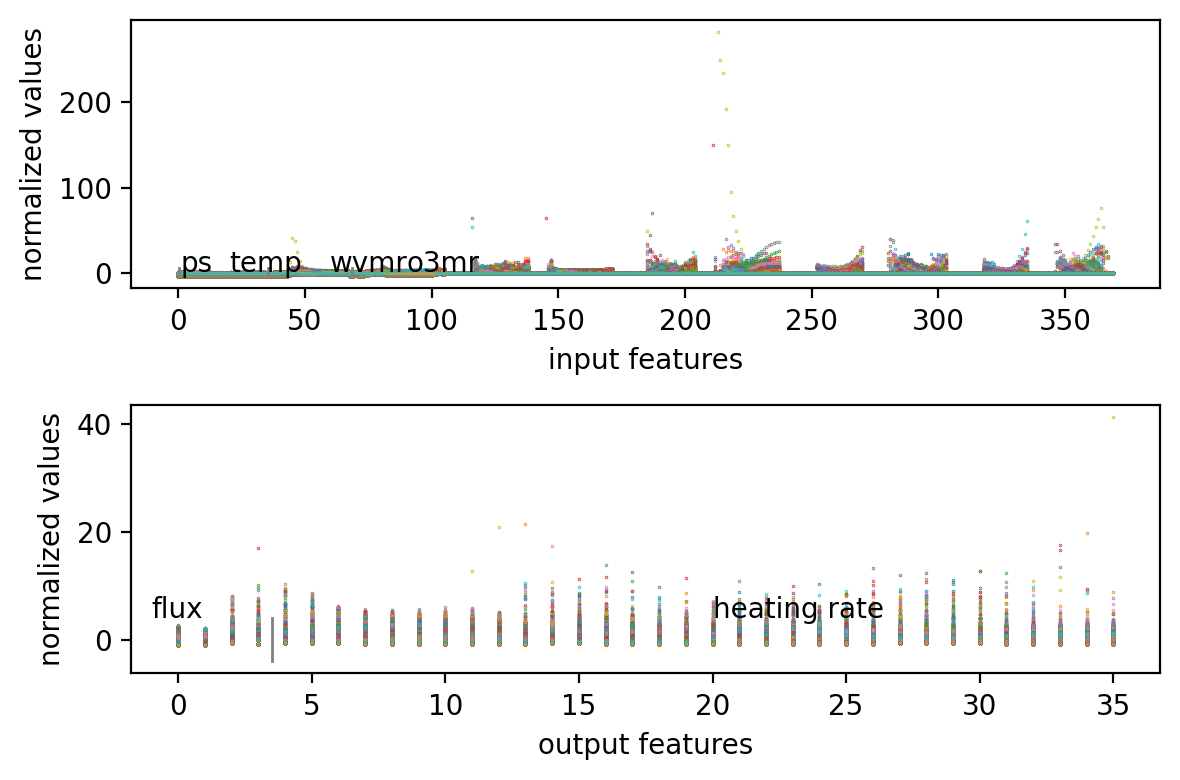

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,4),dpi=200) 

ax = axs[0]
ax.plot(input_array_nor[rd_id,:].T,'.',markersize=0.5)
ax.set_xlabel('input features')
ax.set_ylabel('normalized values')
ax.text(1,1.3,'ps')
ax.plot([0+  0.5, 0+   0.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 10,   1.3,'temp')
ax.plot([0+ 35.5, 0+  35.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 50,   1.3,'wvmr')
ax.plot([0+ 68.5, 0+  68.5],[0,5.5],linewidth = 1,color='grey')
ax.text( 10+ 80,   1.3,'o3mr') 
ax = axs[1]
ax.plot(output_array_nor[rd_id,:].T,'.',markersize=0.5)
ax.set_xlabel('output features')
ax.set_ylabel('normalized values') 
ax.text(-1,4,'flux')
ax.plot([3.5,3.5],[-4,4],linewidth = 1,color='grey')
ax.text(20,4,'heating rate') 
fig.tight_layout()
fig.show()

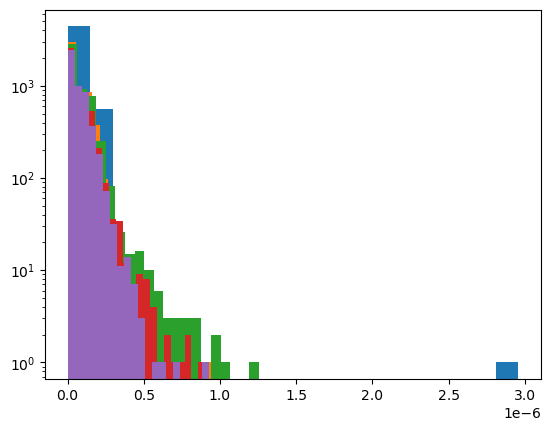

In [9]:
plt.hist(output_array_list[rd_id,-1]*5,bins=20)
plt.hist(output_array_list[rd_id,-5]*5,bins=20)
plt.hist(output_array_list[rd_id,-9]*5,bins=20)
plt.hist(output_array_list[rd_id,-13]*5,bins=20)
plt.hist(output_array_list[rd_id,-17]*5,bins=20)
plt.yscale('log')
# plt.xscale('symlog')
# plt.plot([-1,-1],[0,2000])

# PCA analysis 

In [10]:
#randomly sample the columns
rd_id_more = np.random.randint(0,input_array_nor.shape[0],100000)

In [11]:
X = np.concatenate((input_array_nor[rd_id_more,:],output_array_nor[rd_id_more,:]),axis=1)
# X = input_array_list
n_feature = input_array_nor.shape[1]+output_array_nor.shape[1]
n_components = 40
pca = PCA(n_components=n_components)
pca.fit(X)
n_pc = pca.components_
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.19797312 0.10520046 0.08070519 0.0506894  0.04934787 0.03259907
 0.0297206  0.0235259  0.02273991 0.01858842 0.01747975 0.01625603
 0.01497182 0.01316676 0.01277496 0.01170297 0.0109117  0.01026202
 0.00856771 0.00825511 0.00775262 0.00757289 0.00724849 0.00684601
 0.00635636 0.00612999 0.00588281 0.00555451 0.00544831 0.00522166
 0.00500021 0.00482416 0.00473633 0.00454798 0.00449908 0.00417285
 0.00409936 0.00398373 0.00392028 0.00379043]


0.8430268228113441

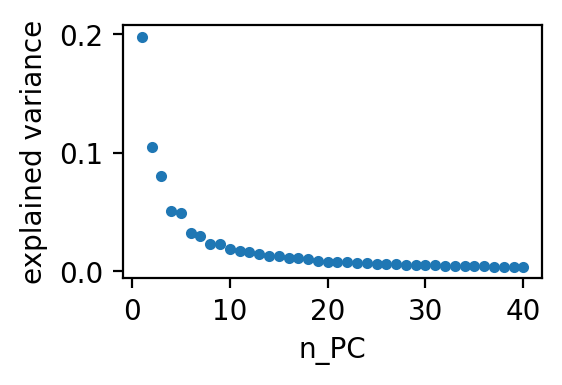

In [12]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,2),dpi=200) 
ax = axs
ax.plot(np.arange(1,n_components+1),pca.explained_variance_ratio_,'.')
ax.set_xlabel('n_PC')
ax.set_ylabel('explained variance')
fig.tight_layout()
fig.show()

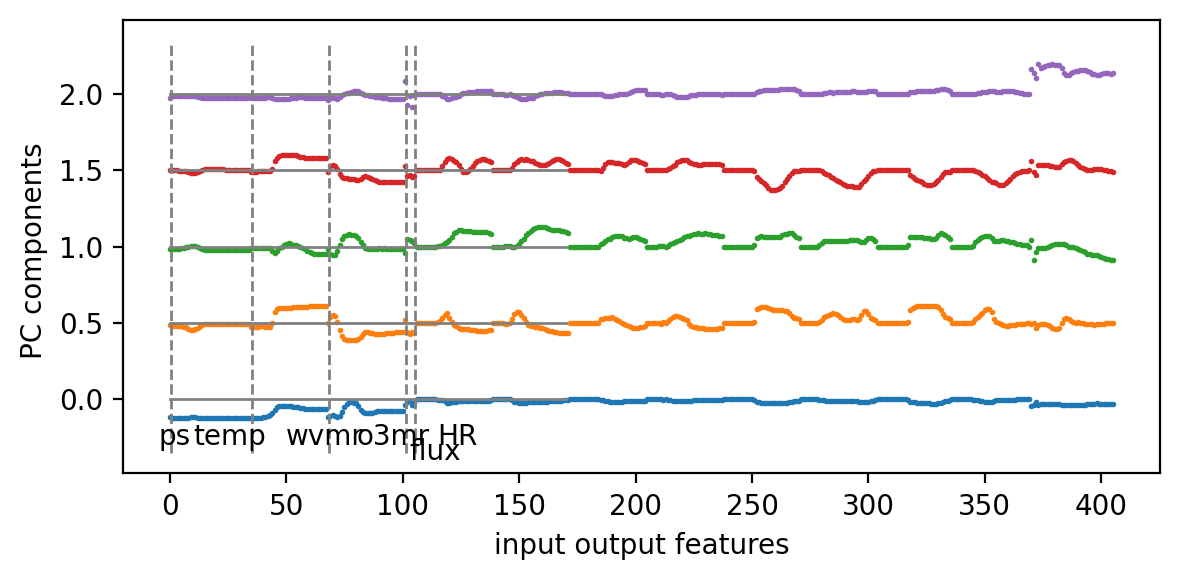

In [13]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,3),dpi=200) 
ax = axs 
for i in range(5):
    ax.plot(np.arange(n_feature),n_pc[i]+0.5*i,'.',markersize=2) 
    ax.plot([  0,  33+137], [0.5*i, 0.5*i],c='grey',linewidth=1) 
ax.text( -5     ,  - 0.3, 'ps')
ax.plot([0+  0.5, 0+   0.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 10,    - 0.3, 'temp')
ax.plot([0+ 35.5, 0+  35.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 50,    - 0.3, 'wvmr')
ax.plot([0+ 68.5, 0+  68.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 80,    - 0.3, 'o3mr')
ax.plot([0+101.5, 0+ 101.5],[-0.35,2.35], '--', linewidth = 1,color='grey') 
ax.text( 0+ 103,   - 0.4, 'flux')
ax.plot([0+ 105.5,0+ 105.5],[-0.35,2.35], '--', linewidth = 1,color='grey')
ax.text( 0+ 115,   - 0.3, 'HR')
ax.set_ylabel('PC components ')
ax.set_xlabel('input output features')
fig.tight_layout()
fig.show()

# Energy conservation

In [14]:
hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values[None,:]
B_k = hybrid_p_sigma_para.bk.values[None,:]
def return_dP_AM4_plev( ps, Ak, Bk): 
    """
    ps: Pa

    return: dP of levels
    """ 
    p_int = Ak + Bk*ps 
    dp = np.diff(p_int)
    return dp

In [15]:
# 'rsdt'  ,'rsutcsaf','rsdscsaf', 'rsuscsaf' ,'tntrscsaf' 

Text(0, 0.5, 'frequency')

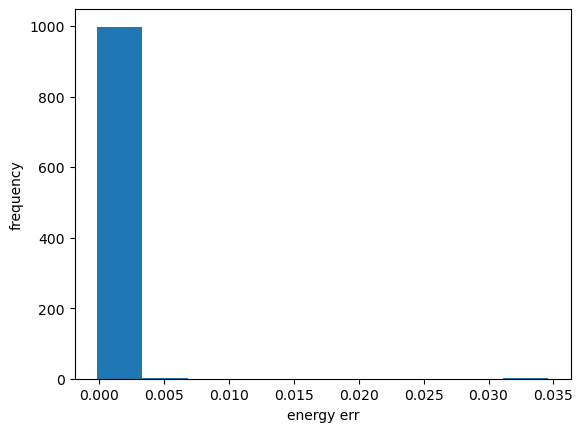

In [16]:

rd_id_e = np.random.randint(0,input_array_nor.shape[0],1000) # sample data
F_sw_toa_do = rsdt_array_list[rd_id_e]
F_sw_toa_up = output_array_list[rd_id_e,0]
F_sw_sfc_do = output_array_list[rd_id_e,1]
F_sw_sfc_up = output_array_list[rd_id_e,2]
F_net = F_sw_toa_do * (1 - F_sw_toa_up + F_sw_sfc_up - F_sw_sfc_do)

C_p = 1004.64       # J/kg/K 
g   = 9.8           # m/s^2 

HR =  output_array_list[rd_id_e,3:]
dP = return_dP_AM4_plev(input_array_list[rd_id_e,0,None],A_k,B_k)
sum_Cphr_gdp = C_p/g * (HR*dP).sum(axis=-1)*F_sw_toa_do

E_err = F_net-sum_Cphr_gdp

plt.hist(E_err)
plt.xlabel('energy err')
plt.ylabel('frequency')

In [17]:
zero_sw_ind = np.argwhere(~np.isclose(F_sw_toa_do,0)).squeeze()

In [18]:
zero_sw_ind.shape

(597,)

In [19]:
((E_err**2).mean())**0.5

0.0011050132471409023